In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
def plot_measures(values,labels,titulo, x_rotation, fig_size=(8,8)):
        
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(figsize=fig_size)
    rects1 = ax.bar(ind, values, width,color='SkyBlue')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Conteos')
    ax.set_title(titulo)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation = x_rotation)
    
    autolabel(rects1,ax, "center")
    plt.show()
    
def autolabel(rects, ax,xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                height, ha=ha[xpos], va='bottom')    

In [3]:
data_dir = os.path.join('data xm','Precio','Precio Bolsa Nacional')
data_list = list()
real_columns_names = ['Fecha'] + [str(i) for i in np.arange(24)]

In [4]:
shape_count = 0
for root, dirs, files in os.walk(data_dir, topdown=False):
    for file in files:
        f = pd.read_excel(os.path.join(root,file))
        f.columns = real_columns_names
        shape_count += f.shape[0]
        data_list.append(f)
        print(os.path.join(root,file),f.shape)

data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_1995.xlsx (165, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_1996.xlsx (366, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_1997.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_1998.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_1999.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2000.xlsx (366, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2001.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2002.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2003.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2004.xlsx (366, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Nacional_($kwh)_2005.xlsx (365, 25)
data xm\Precio\Precio Bolsa Nacional\Precio_Bolsa_Naci

In [5]:
full_data = pd.concat(data_list)

In [6]:
assert shape_count == full_data.shape[0], 'No coinciden las dimensiones'

In [7]:
full_data.dropna(inplace=True,how='all')

In [8]:
full_data.shape

(9141, 25)

In [9]:
full_data.columns

Index(['Fecha', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

# GENERAR DATASET CON SERIE

In [10]:
def construir_dataset(df_transpuesto):
    lambda_horas = lambda x: pd.Timedelta(datetime.datetime.strptime(x,'%H').hour, unit='hours')
    
    df_transpuesto['Fecha'] =  pd.to_datetime(df_transpuesto['Fecha'], format='%Y-%m-%d')
    df_transpuesto['variable'] = df_transpuesto['variable'].map(lambda_horas)
    
    df_transpuesto['Fecha'] = df_transpuesto['Fecha'] +  df_transpuesto['variable']
    df_transpuesto = df_transpuesto.sort_values(['Fecha'])
    df_transpuesto.drop('variable', axis=1, inplace = True)
    df_transpuesto.rename(columns={"value": "$kWh"}, inplace = True)
    df_transpuesto['$kWh'].fillna(value=0, inplace=True)
    
    return df_transpuesto

In [11]:
def dividir_guardar_dataset(dataset,dataset_path,dataset_name):
    maximas_filas_excel = 1048576
    filas_dataset = dataset.shape[0]
    divisiones = 1
    
    if filas_dataset > maximas_filas_excel:
        divisiones = math.ceil(filas_dataset/maximas_filas_excel)
        
    lista_dataset = np.array_split(dataset, divisiones)
    for idx,df in enumerate(lista_dataset):
        df.to_excel(os.path.join(dataset_path,'{}_{}.xlsx'.format(dataset_name,idx)))
        print('---> Tamaño División: {}'.format(df.shape))

In [12]:
datos_copy = full_data.copy()

In [13]:
df_transpuesto = pd.melt(datos_copy,
                     id_vars=['Fecha'],
                     value_vars=['0', '1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12',
                                 '13', '14', '15', '16','17', '18', '19', '20', '21', '22', '23'])

dataset = construir_dataset(df_transpuesto)

In [15]:
dataset_path = os.path.join('data series','Precio','Bolsa Nacional')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

dividir_guardar_dataset(dataset,dataset_path,dataset_name='Bolsa Nacional')

---> Tamaño División: (219384, 2)


# Visualización de los datos

In [16]:
def indexar_dataset(data):
    
    dataset = data.copy()
    dataset = dataset.set_index('Fecha')
    
    dataset['Año'] = dataset.index.year
    dataset['Mes'] = dataset.index.month
    dataset['Dia'] = dataset.index.day_name()
    
    return dataset

In [17]:
def grafico_comportamiento(datos):
    cols_plot = ['$kWh']
    nombre_graficas = ['$kWh']
    axes = datos[cols_plot].plot(alpha=0.8, linestyle='-', figsize=(15, 5), subplots=True)
    for ax,name in zip(axes,nombre_graficas):
        ax.set_ylabel(name)

In [18]:
def grafico_comportamiento_por_mes(datos):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    
    sns.boxplot(data=datos, x='Mes', y='$kWh', ax=ax)
    ax.set_title('$kWh')

In [19]:
def grafico_filtrado_fecha(datos,fecha_min,fecha_max):
    ax = datos.loc[fecha_min:fecha_max, '$kWh'].plot(marker='o',linestyle='-',figsize=(15, 5))
    ax.set_ylabel('$kWh');

In [20]:
def grafico_resampling_rolling_window(datos,fecha_min,fecha_max):
    cols_plot = ['$kWh']
    datos_7d = datos[cols_plot].rolling(7, center=True).mean()

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(datos.loc[fecha_min:fecha_max, '$kWh'],
    marker='.', linestyle='-', linewidth=0.5, label='Diaria')

    ax.plot(datos_7d.loc[fecha_min:fecha_max, '$kWh'],linestyle='-', label='Media Movil 7-Días')

    ax.set_ylabel('$kWh')
    ax.legend();

In [21]:
dataset = indexar_dataset(dataset)

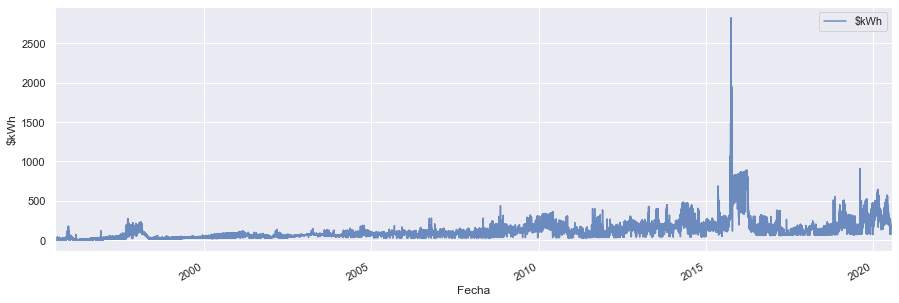

In [22]:
grafico_comportamiento(dataset)

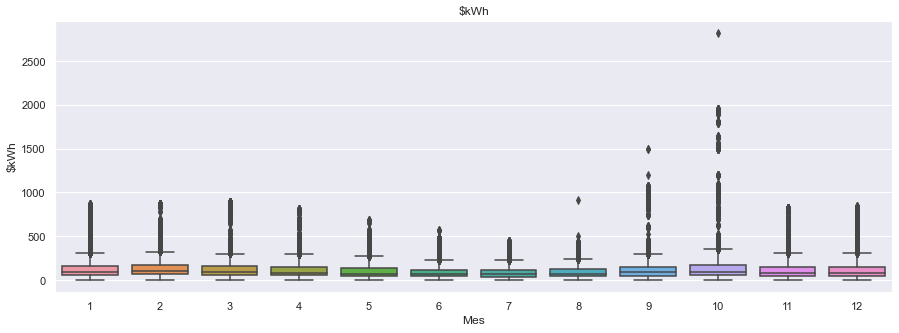

In [23]:
grafico_comportamiento_por_mes(dataset)

In [24]:
'Fecha Mínima {} - Fecha Máxima {}'.format(dataset.index.min(),dataset.index.max())

'Fecha Mínima 1995-07-20 00:00:00 - Fecha Máxima 2020-07-28 23:00:00'

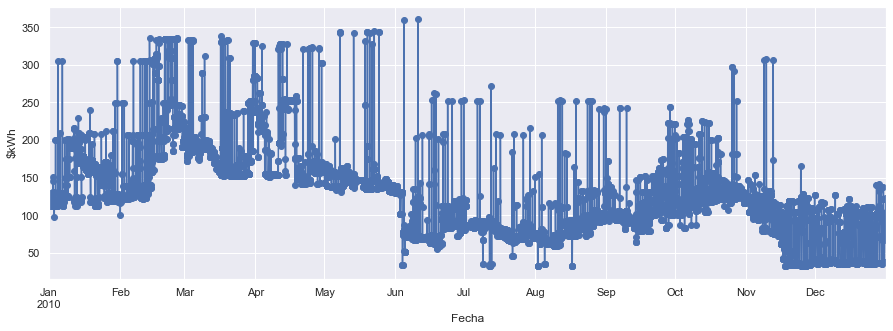

In [25]:
grafico_filtrado_fecha(datos=dataset,fecha_min='2010-01',fecha_max='2010-12')

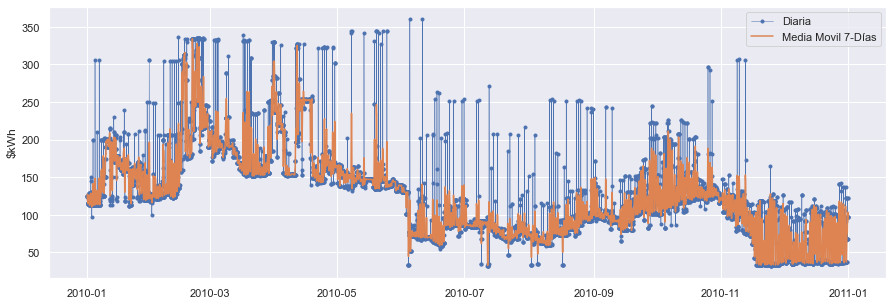

In [26]:
grafico_resampling_rolling_window(datos=dataset,fecha_min='2010-01',fecha_max='2010-12')